# Pub accessibility for Inner London

Install and update `cityseer` if necessary.

In [1]:
# !pip install --upgrade cityseer

## Data and preparation

> Pubs (data provided by CAMRA in January 2019)
> https://data.london.gov.uk/download/cultural-infrastructure-map/7e6b0f36-da01-4029-99d7-640d89c4a0a4/Pubs.csv
> Buildings defined by CAMRA as pubs. Licensed premises must be open to and welcome the general public without requiring membership or residency, allow free entry (1), serve at least one draught beer (2), allow drinking without requiring food to be consumed, have at least one indoor area not laid out for meals, and permit drinks to be purchased in person at a bar (3), without relying on table service.’ (1) Except when entertainment is provided on limited occasions (2) Includes cask or keg beer (3) Includes also a hatch or specific service point’
> How data was compiled: Data provided by the Campaign for Real Ale.
> Credit for use: The Campaign for Real Ale

This examples calculates landuse accessibility to pubs for inner London.

For additional information on network preparation, see the corresponding notebook on [graph cleaning](https://colab.research.google.com/github/cityseer/cityseer/blob/master/demos/graph_cleaning.ipynb).

This example will make use of OSM data downloaded from the [OSM API](https://wiki.openstreetmap.org/wiki/API) for a 5000m radius around London Soho.

In [2]:
from shapely import geometry

from cityseer.tools import graphs, io

# download from OSM
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 5000
plot_buffer = 3500
# creates a WGS shapely polygon
poly_wgs, poly_utm, _utm_zone_number, _utm_zone_letter = io.buffered_point_poly(lng, lat, buffer)
plot_bbox = poly_utm.centroid.buffer(plot_buffer).bounds

/Users/gareth/dev/benchmark-urbanism/cityseer-api/.venv/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
INFO:cityseer.tools.io:UTM conversion info: UTM zone number: 30, UTM zone letter: U


## Load

We can now load the OSM street network and convert it to a format that can be used by cityseer for downstream calculations.

In [4]:
# generate OSM graph from polygon
G_utm = io.osm_graph_from_poly_wgs(poly_wgs, simplify=True, remove_parallel=True, iron_edges=True)
# decompose for higher resolution analysis
G_decomp = graphs.nx_decompose(G_utm, 25)
# prepare the data structures
nodes_gdf, network_structure = graphs.network_structure_from_nx(G_decomp, crs=32629)

INFO:cityseer.tools.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 143342/143342 [00:12<00:00, 11594.70it/s]
INFO:cityseer.tools.graphs:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 161157/161157 [00:00<00:00, 925843.19it/s]
INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 161157/161157 [00:01<00:00, 104295.57it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 143342/143342 [00:21<00:00, 6780.20it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 45926/45926 [00:00<00:00, 348206.71it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 41651/41651 [00:00<00:00, 48410.02it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/tools/graphs.py:1049: Sh

In [5]:
# prepare data layer
import pandas as pd
import geopandas as gpd
from cityseer.metrics import layers

# load data from URL
pubs_data_io = pd.read_csv(
    "https://data.london.gov.uk/download/cultural-infrastructure-map/7e6b0f36-da01-4029-99d7-640d89c4a0a4/Pubs.csv"
)
pubs_data_gdf = gpd.GeoDataFrame(
    pubs_data_io, crs=27700, geometry=gpd.points_from_xy(pubs_data_io.easting, pubs_data_io.northing)
)
# convert to the same UTM CRS as the network
pubs_data_gdf = pubs_data_gdf.to_crs(32630)  # to match EPSG code for UTM zone 30N per network data
# all pubs will have the same landuse category
pubs_data_gdf["landuse_category"] = "pub"
print(pubs_data_gdf.head())
# compute pub accessibility
nodes_gdf, pubs_data_gdf = layers.compute_accessibilities(
    pubs_data_gdf,
    landuse_column_label="landuse_category",
    accessibility_keys=["pub"],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=[100, 200, 400, 800],
)

             name            address1 address2    address3 borough_name  \
0       Harlequin    27 Arlington Way   London    Finsbury    Islington   
1         Peasant  240 St John Street   London    Finsbury    Islington   
2   Blues Kitchen    134 Curtain Road   London  Shoreditch      Hackney   
3  Caraway Lounge    290 North Street  Romford         NaN     Havering   
4             Rye      31 Peckham Rye  Peckham      London    Southwark   

   website  os_addressbase_uprn borough_code            ward_2018_name  \
0      NaN                  NaN    E09000019               Clerkenwell   
1      NaN                  NaN    E09000019               Clerkenwell   
2      NaN                  NaN    E09000012  Hoxton East & Shoreditch   
3      NaN                  NaN    E09000016                Brooklands   
4      NaN                  NaN    E09000028                  Rye Lane   

  ward_2018_code        easting       northing  longitude   latitude  \
0      E05000370  531467.000122 

INFO:cityseer.metrics.layers:Computing land-use accessibility for: pub


  0%|          | 0.0/89747 [00:12<?, ?it/s]

/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/algos/data.py:524: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  reachable_data, reachable_data_dist = aggregate_to_src_idx(


100%|██████████| 89747.0/89747 [01:06<00:00, 1347.90it/s]



    Distance weighted Pub accessibility:
    Avg walking tolerance: 35.12m
    Beta: 0.040 (spatial impedance factor)
    Max walking tolerance: 100m
    


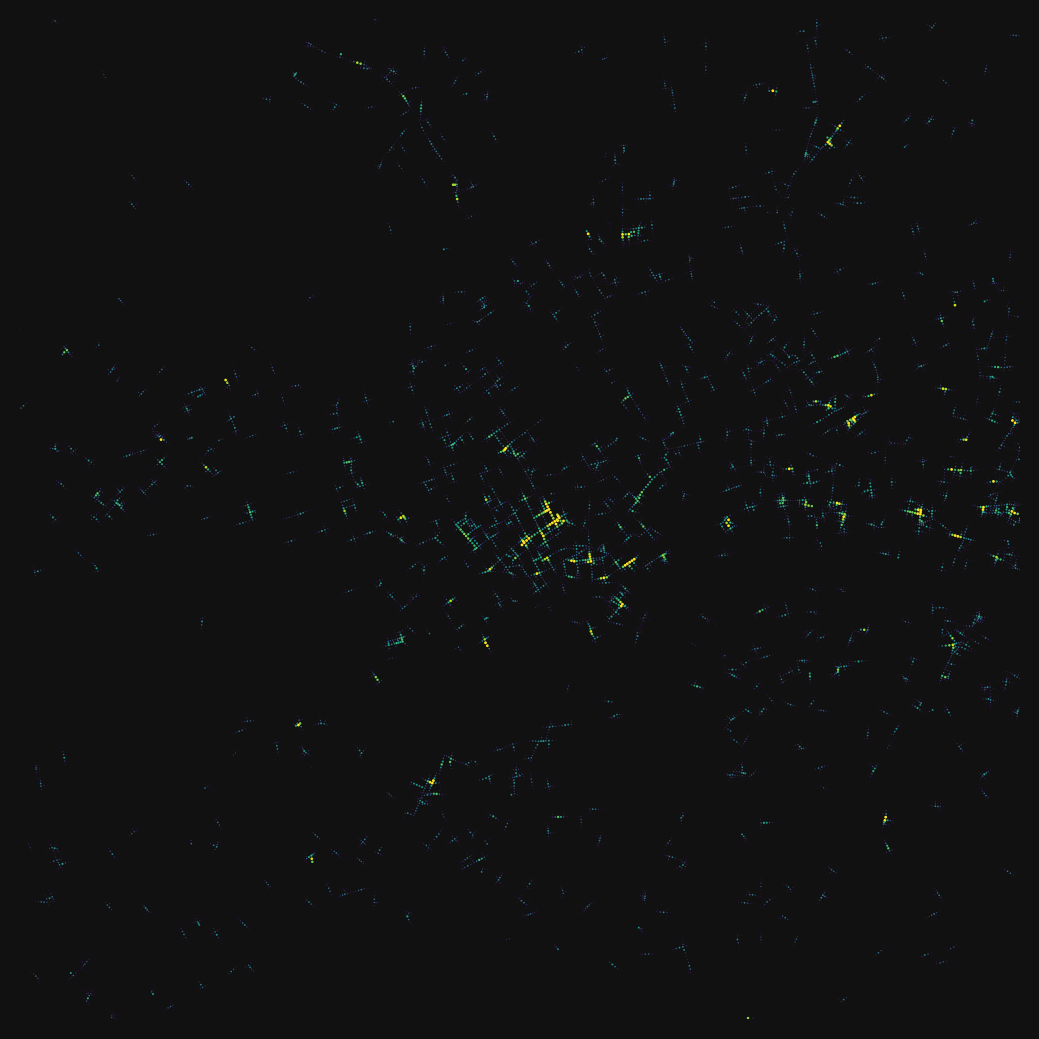


    Distance weighted Pub accessibility:
    Avg walking tolerance: 70.24m
    Beta: 0.020 (spatial impedance factor)
    Max walking tolerance: 200m
    


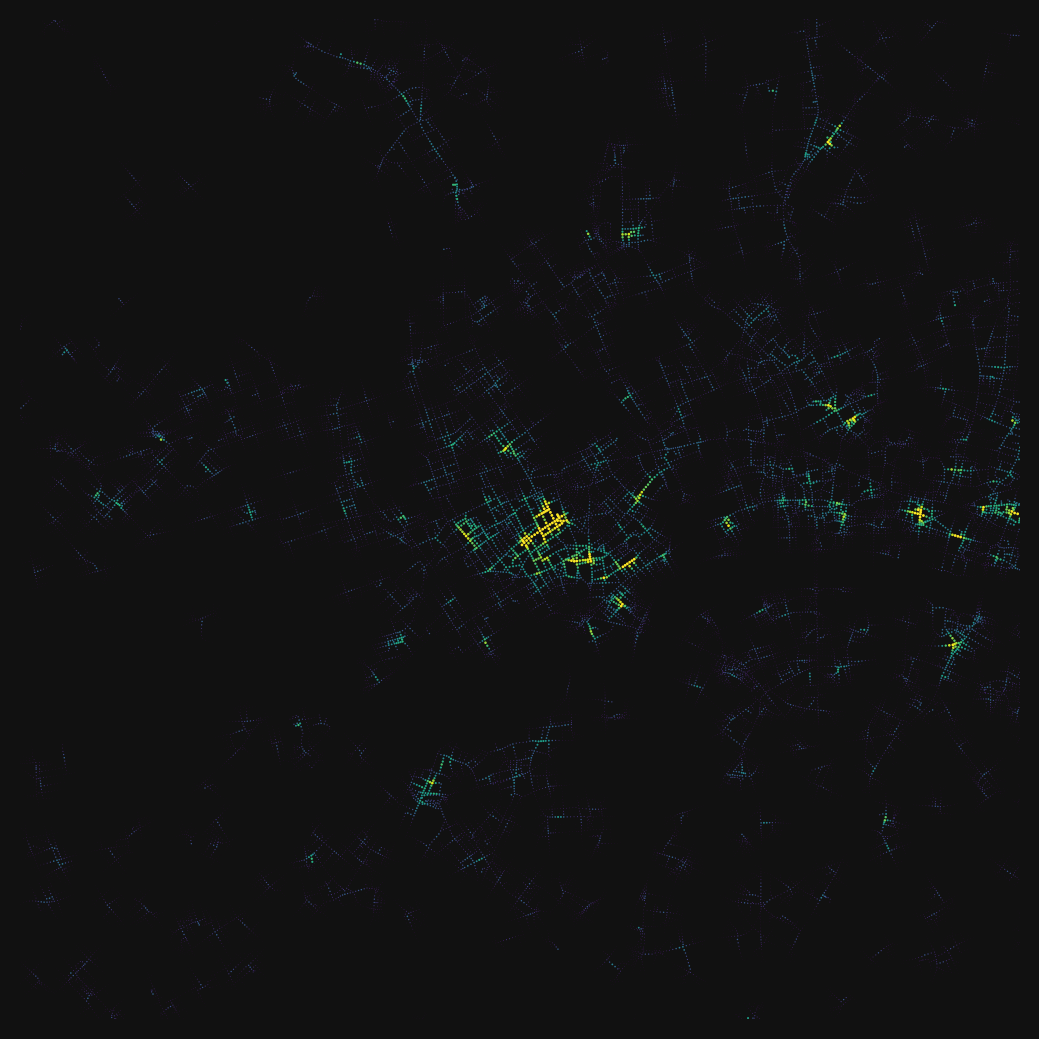


    Distance weighted Pub accessibility:
    Avg walking tolerance: 140.48m
    Beta: 0.010 (spatial impedance factor)
    Max walking tolerance: 400m
    


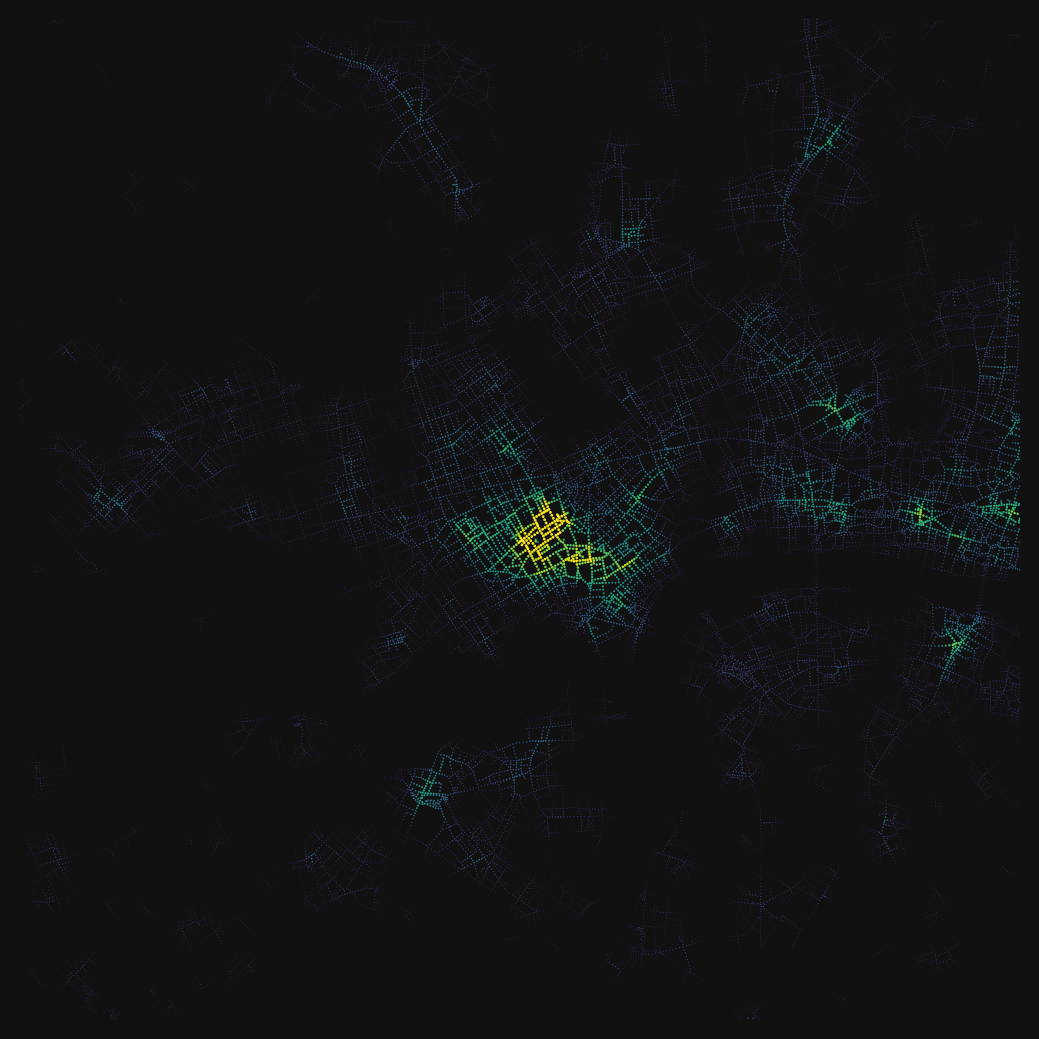


    Distance weighted Pub accessibility:
    Avg walking tolerance: 280.96m
    Beta: 0.005 (spatial impedance factor)
    Max walking tolerance: 800m
    


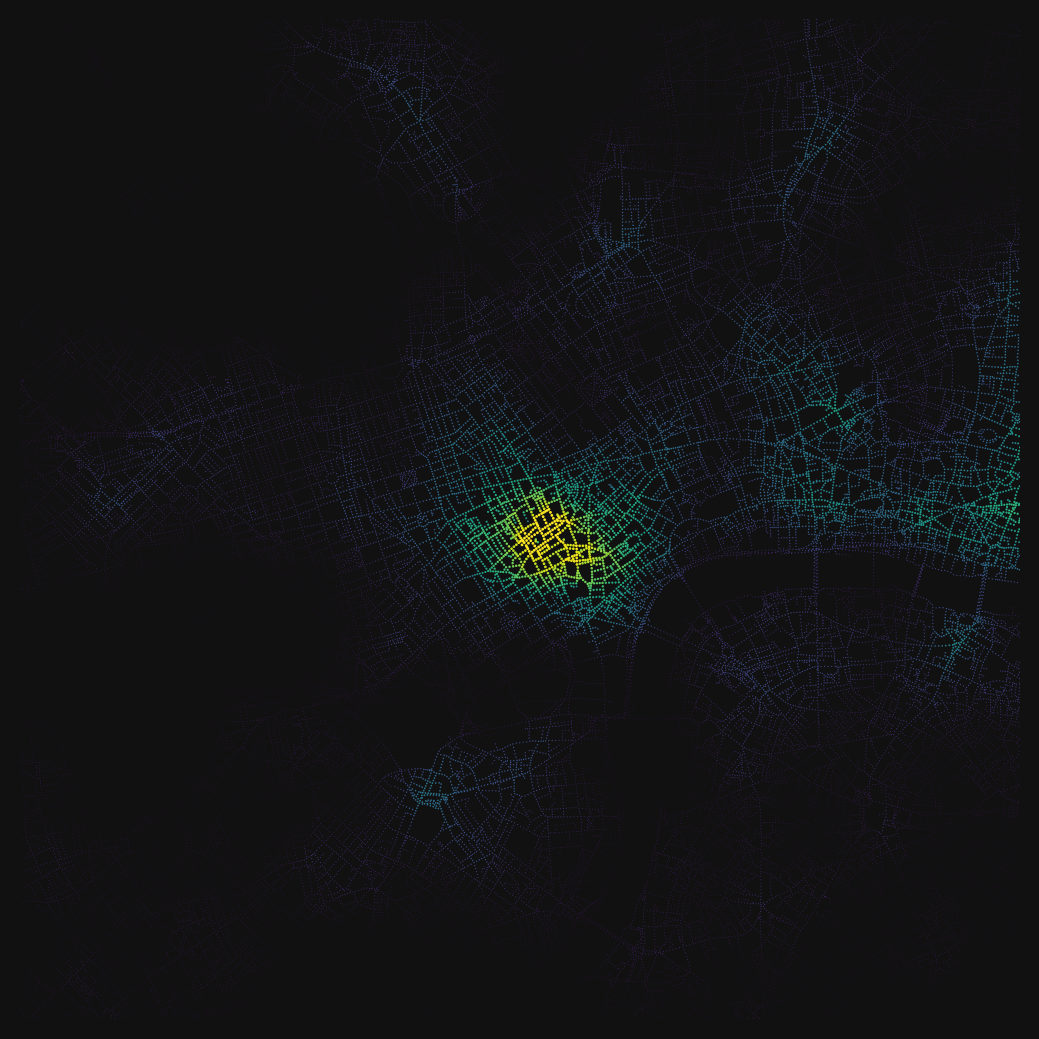

In [7]:
import matplotlib.pyplot as plt

from cityseer.metrics import networks

from demos.general_util import plot_funcs

for d in [100, 200, 400, 800]:
    b = networks.beta_from_distance(d)[0]
    avg_d = networks.avg_distance_for_beta(float(b))[0]
    print(
        f"""
    Distance weighted Pub accessibility:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b:.3f} (spatial impedance factor)
    Max walking tolerance: {d}m
    """
    )
    bg_colour = '#111'
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, facecolor=bg_colour)
    fig.subplots_adjust(0,0,1,1)
    plot_funcs.plot_scatter(
        ax,
        network_structure.nodes.xs,
        network_structure.nodes.ys,
        nodes_gdf[f"cc_metric_pub_{d}_weighted"],
        bbox_extents=plot_bbox,
        cmap_key='viridis',
        face_colour=bg_colour,
    )
    ax.axis('off')
    plt.show()
